# DMT
Mazeworld with discrete morse theory

In [1]:
import sys

sys.path.append("../src")

from environments import LineEnv, GridEnv, MazeEnv
from policies import BaseAgent, QLearningAgent
import matplotlib.pyplot as plt
import networkx as nx


import numpy as np

In [2]:
env = MazeEnv()
agent = BaseAgent(env, gamma=1)
agent.value_iteration()
optimal_value_function = agent.value_function

print("Optimal Value Function:", agent.value_function)
print("Optimal Policy:", agent.policy)

Optimal Value Function: [-8.999916 -7.999922 -6.999929 -5.999937 -4.999946 -3.999956  0.
 -7.999916 -6.999923 -5.999931 -4.99994  -3.99995  -2.999961 -1.999973
 -0.999986 -8.999874 -7.999889 -6.999905 -5.999922 -3.999942 -1.999966
 -9.999668 -8.999689 -7.99973  -6.999753 -4.999917 -2.99994  -7.999711
 -5.999777 -5.999804 -4.999833 -3.999863 -2.999894 -6.999738 -5.999771
 -4.999805 -1.999926 -3.99984  -0.999962  0.       -0.99996  -1.999919
 -2.999877 -2.999868 -1.999911 -0.999955  0.      ]
Optimal Policy: [0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 1 1 1 2 2 2 1 0 1 0 2 2 0 0 1 1 1 0 1 1 0 0
 0 0 0 3 3 3 1 1 1 0]


In [3]:
env = MazeEnv()
agent = QLearningAgent(env, gamma=1, alpha=0.1)
agent.compute_optimal_q_function()
optimal_q_function = agent.q_table

Optimal Q-function computed.


In [4]:
agent.q_table[0]

array([-8.999916, -8.999922, -9.999916, -9.999916])

In [5]:
optimal_value_function[0]

-8.999915999999999

In [6]:
# check if optimal q is optimal v
np.all(np.max(agent.q_table, axis=-1) == optimal_value_function)

True

# env to graph

TODO: Must be careful about nodes and edges and double counting edges. Define graph exactly as needed. Otherwise we have a wonky discrete morse function calculation. i.e. and edge is defined as connecting two states iff you actually move to that state (no bonking to a wall)

In [7]:

env._state_to_grid.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [8]:
# sort a tuple (state, next_state) so that it is always in the same order

sorted_tuple = lambda x: tuple(sorted(x))

In [9]:
# Create a directed graph
G = nx.Graph()

node_values = {}
edge_values = {}


# Add vertices (states) to the graph
for state in env._state_to_grid.keys():
    G.add_node(state)
    node_values[state] = np.max(optimal_q_function[state])

# Add edges (actions) to the graph
for state in G.nodes:
    if state in env.terminal_states:
        continue
    for action in range(4):  # There are four possible actions: up, right, down, left
        next_state, reward = env.get_next_state_and_reward(state, action)
        if next_state == state:
            continue
        if sorted_tuple((state, next_state)) in edge_values:
            current_q_value = edge_values[sorted_tuple((state, next_state))]
        else:
            current_q_value = -np.inf

        G.add_edge(state, next_state)
        edge_values[sorted_tuple((state, next_state))] = np.max(
            [optimal_q_function[state][action], current_q_value]
        )

# Now G is the graph representation of the environment
G.nodes(), G.edges(data=True)

(NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46)),
 EdgeDataView([(0, 7, {}), (0, 1, {}), (1, 8, {}), (1, 2, {}), (2, 9, {}), (2, 3, {}), (3, 10, {}), (3, 4, {}), (4, 11, {}), (4, 5, {}), (5, 12, {}), (6, 14, {}), (7, 15, {}), (7, 8, {}), (8, 16, {}), (8, 9, {}), (9, 17, {}), (9, 10, {}), (10, 18, {}), (10, 11, {}), (11, 12, {}), (12, 19, {}), (12, 13, {}), (13, 14, {}), (14, 20, {}), (15, 21, {}), (15, 16, {}), (16, 22, {}), (16, 17, {}), (17, 23, {}), (17, 18, {}), (18, 24, {}), (19, 25, {}), (20, 26, {}), (21, 22, {}), (22, 27, {}), (22, 23, {}), (23, 24, {}), (24, 28, {}), (25, 30, {}), (26, 32, {}), (27, 33, {}), (28, 35, {}), (28, 29, {}), (29, 30, {}), (30, 31, {}), (31, 32, {}), (32, 36, {}), (33, 34, {}), (34, 35, {}), (35, 37, {}), (36, 38, {}), (37, 42, {}), (38, 46, {}), (39, 40, {}), (40, 41, {}), (41, 42, {}), (42, 43, {}), (43, 44, {

In [10]:
# Step 1: Define a Real-Valued Function on the Graph
# Assigning a random value to each node
# node_values = {node: float(optimal_value_function[node]) for node in G.nodes}
# edge_values = {(u, v): max(node_values[u], node_values[v]) for u, v in G.edges}

# Adding the values as a node attribute
nx.set_node_attributes(G, node_values, "node_value")
nx.set_edge_attributes(G, edge_values, "edge_value")

In [11]:
list(G.nodes(data=True))[:5]

[(0, {'node_value': -8.999915999999999}),
 (1, {'node_value': -7.999922}),
 (2, {'node_value': -6.999929}),
 (3, {'node_value': -5.999937000000001}),
 (4, {'node_value': -4.9999460000000004})]

In [12]:
list(G.edges(data=True))[:5]

[(0, 7, {'edge_value': -8.999915999999999}),
 (0, 1, {'edge_value': -8.999922}),
 (1, 8, {'edge_value': -7.999922}),
 (1, 2, {'edge_value': -7.999928}),
 (2, 9, {'edge_value': -6.999929})]

In [13]:
G.nodes[0]

{'node_value': -8.999915999999999}

In [14]:
G[0]

AtlasView({7: {'edge_value': -8.999915999999999}, 1: {'edge_value': -8.999922}})

In [15]:
import networkx as nx

# Assuming G is already defined and populated with your nodes and edges


def classify_simplices(G):
    critical_nodes = []
    regular_nodes = []
    critical_edges = []
    regular_edges = []

    # Function to classify nodes
    for node, data in G.nodes(data=True):
        node_value = -data["node_value"]  # take negative of value fn to get morse fn
        edges = G.edges(node, data=True)
        exception_count = sum(
            -edge_data["edge_value"] <= node_value for _, _, edge_data in edges
        )  # take negative of edge value to get morse fn

        if exception_count == 0:
            critical_nodes.append(node)
        elif exception_count == 1:
            regular_nodes.append(node)
        else:
            print(node, data, exception_count)
            return None, None, None, None  # Not a discrete Morse function

    # Function to classify edges
    for edge in G.edges(data=True):
        edge_value = -edge[2]["edge_value"]
        faces = [edge[0], edge[1]]
        exception_count = sum(
            -G.nodes[face]["node_value"] >= edge_value for face in faces
        )

        if exception_count == 0:
            critical_edges.append(edge)
        elif exception_count == 1:
            regular_edges.append(edge)
        else:
            print(edge, edge_value, exception_count)
            return None, None, None, None  # Not a discrete Morse function

    return critical_nodes, regular_nodes, critical_edges, regular_edges

In [16]:
# Run the classification function
critical_nodes, regular_nodes, critical_edges, regular_edges = classify_simplices(G)

# Check if it's a discrete Morse function and print the results
if critical_nodes is not None:
    print("Discrete Morse function found")
    print("Critical Nodes:", critical_nodes)
    print("Regular Nodes:", regular_nodes)
    print("Critical Edges:", critical_edges)
    print("Regular Edges:", regular_edges)
else:
    print("Not a discrete Morse function")

Discrete Morse function found
Critical Nodes: [6, 39, 46]
Regular Nodes: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45]
Critical Edges: [(0, 1, {'edge_value': -8.999922}), (1, 2, {'edge_value': -7.999928}), (2, 3, {'edge_value': -6.999935000000001}), (3, 4, {'edge_value': -5.999943}), (4, 5, {'edge_value': -4.999952}), (7, 15, {'edge_value': -8.999901}), (8, 16, {'edge_value': -7.999907}), (9, 17, {'edge_value': -6.999914}), (15, 21, {'edge_value': -9.999853000000002}), (16, 22, {'edge_value': -8.999867000000002}), (17, 23, {'edge_value': -7.999882000000001}), (18, 24, {'edge_value': -6.999898000000001}), (22, 23, {'edge_value': -8.999708}), (25, 30, {'edge_value': -5.999808}), (26, 32, {'edge_value': -3.9998679999999998}), (28, 29, {'edge_value': -6.999748}), (42, 43, {'edge_value': -3.999826})]
Regular Edges: [(0, 7, {'edge_value': -8.999915999999999}), (1, 8, {'ed

In [17]:
critical_edges

[(0, 1, {'edge_value': -8.999922}),
 (1, 2, {'edge_value': -7.999928}),
 (2, 3, {'edge_value': -6.999935000000001}),
 (3, 4, {'edge_value': -5.999943}),
 (4, 5, {'edge_value': -4.999952}),
 (7, 15, {'edge_value': -8.999901}),
 (8, 16, {'edge_value': -7.999907}),
 (9, 17, {'edge_value': -6.999914}),
 (15, 21, {'edge_value': -9.999853000000002}),
 (16, 22, {'edge_value': -8.999867000000002}),
 (17, 23, {'edge_value': -7.999882000000001}),
 (18, 24, {'edge_value': -6.999898000000001}),
 (22, 23, {'edge_value': -8.999708}),
 (25, 30, {'edge_value': -5.999808}),
 (26, 32, {'edge_value': -3.9998679999999998}),
 (28, 29, {'edge_value': -6.999748}),
 (42, 43, {'edge_value': -3.999826})]

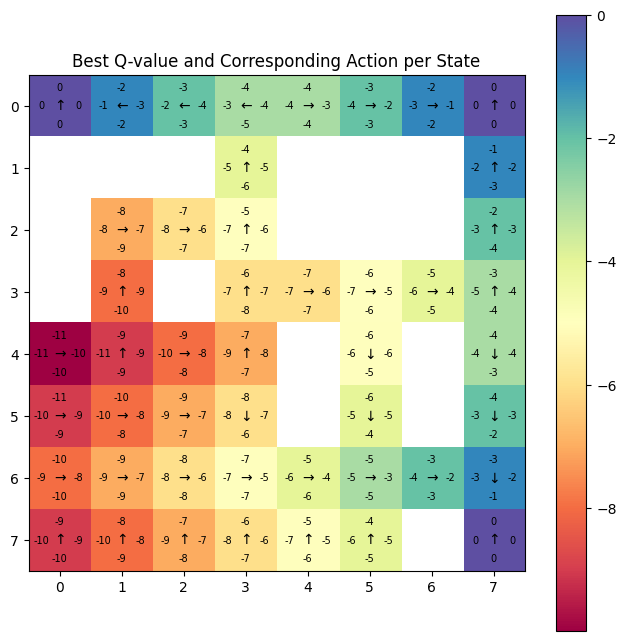

In [18]:
agent.plot_best_action_q_values()

In [19]:
def visualize_graph(G, env, critical_nodes, critical_edges):
    # Get node positions from env._state_to_grid
    pos = {state: env._state_to_grid[state] for state in G.nodes}

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Draw the graph
    nx.draw(G, pos, with_labels=False, node_color="black", node_size=100, ax=ax)

    # Highlight critical nodes and edges in red
    nx.draw_networkx_nodes(G, pos, nodelist=critical_nodes, node_color="red", node_size=100, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=critical_edges, edge_color="red", ax=ax)

    # Show the plot
    plt.show()

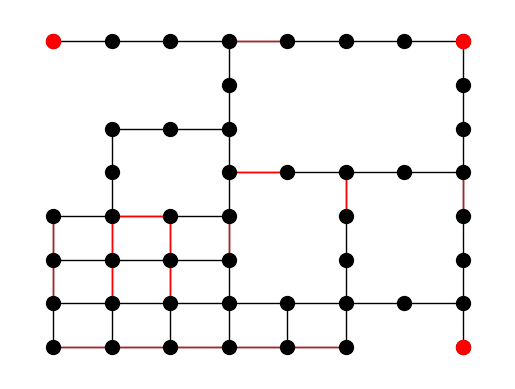

In [20]:
visualize_graph(G, env, critical_nodes, critical_edges)